# Self-driving Car Nanodegree

Project 3: Vehicle Detection and Tracking
---
Write-up by Toan Luong. Updated 9/9/2018.

Problem Description
---

The goal of the project is to write a software pipeline to detect vehicles in a video.

The steps are as below
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Implement a sliding-window technique and use the trained classifier to search for vehicles in images.
* Run the pipeline on a video stream and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Draw and estimate a bounding box for vehicles detected.

1. HOG Feature Extraction
---

In [1]:
import numpy as np
import pickle
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Import & visualize the cars and not-cars dataset

A few images are shown below. Our dataset contains small crops of cars and non-car instances to be fed into the classifier. We will investigate their distribution after extracting the HOG features.

In [2]:
car_dataset = pickle.load(open("car_dataset.p", "rb"))
cars, notcars = np.asarray(car_dataset['car']), np.asarray(car_dataset['noncar'])

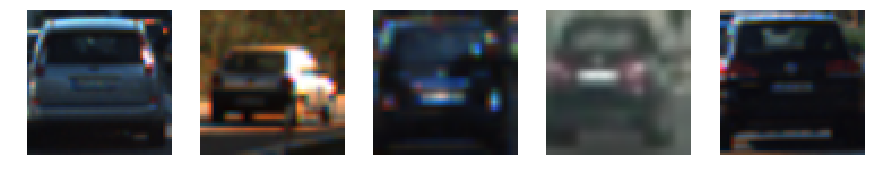

In [3]:
plt.figure(figsize=(15,15))
for i, img in enumerate(cars[np.random.randint(len(cars), size=5)]):   
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

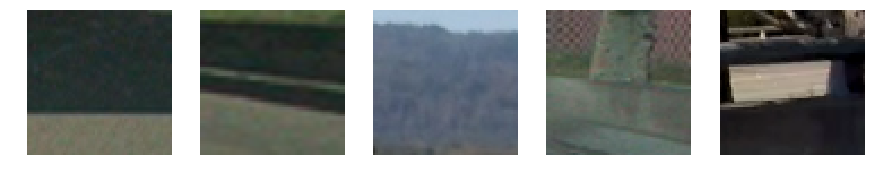

In [4]:
plt.figure(figsize=(15,15))
for i, img in enumerate(notcars[np.random.randint(len(cars), size=5)]):   
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

### Setting up HOG feature extraction pipeline

`get_hog` asks for the image, orientation, pixels per cell, cells per block to customize the shape of HOG return features. There is a `vis` option if set to `True` will return a `hog_image` to show the direction of oriented gradients.

Based on several experiments and class lessons, I settled at `orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)` as the default parameters to optimize extraction speed while maintaining quality.

A few visualizing examples are discussed below.

In [5]:
from skimage.feature import hog
def get_hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), vis=False):
    """Extract HOG features from a channel
    
    skimage.feature.hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), 
    block_norm=None, visualize=False, visualise=None, transform_sqrt=False, feature_vector=True, multichannel=None)
    
    out: (n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient) ndarray
    HOG descriptor for the image. If feature_vector is True, a 1D (flattened) array is returned.

    hog_image : (M, N) ndarray, optional
    A visualisation of the HOG image. Only provided if visualize is True.
    
    """
    if vis:
        hog_features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, 
                                      cells_per_block=cells_per_block, visualise=vis)
        plt.figure()
        plt.subplot(121)
        plt.imshow(img, cmap='gray')
        plt.subplot(122)
        plt.imshow(hog_image, cmap='gray')
        plt.show()
        return hog_features
    else:
        return hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
    
def dense_SIFT(image, density=0.05, display=False):
    """Generate dense SIFT descriptors
    Args:
        image: A numpy array representing the image, which is of type np.int in range [0, 255] of size
            (H x W x 3) in RGB order (eg. output of cv2.imread).
        density: Decide the density of the descriptors.

    Returns:
      result: A one level 128-dimension list with the mean description value of total descriptors.
    """
    # Convert into gray pic
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.uint8)
    # Generate a sift to calculate description vector later
    sift = cv2.xfeatures2d.SIFT_create()

    # The step to evenly pick the description point
    # Use the short side len multiply density
    step_size = round(min(image.shape[0], image.shape[1]) * density)

    # Calculate the points with step_size
    kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, gray.shape[0], step_size)
          for x in range(0, gray.shape[1], step_size)]

    # Calculate the description vector for each points
    dense_feat = sift.compute(gray, kp)

    # Without flattening
    # return dense_feat[1]
    
    if display:
        cv2.drawKeypoints(gray, kp, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.figure()
        plt.imshow(image[:, :, ::-1])
        plt.show()

    # Flatten the n description vectors, n for the num of description points
    return np.mean(dense_feat[1], axis=0)

This is an example of `hog_image` applied the RGB channel space. As shown, the gradients detect the car edges pretty well.

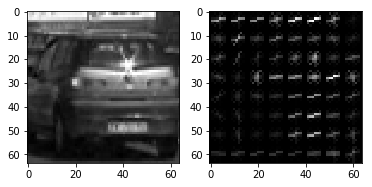

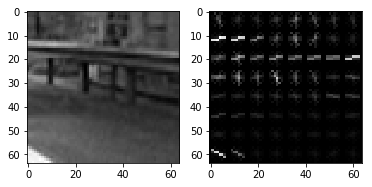

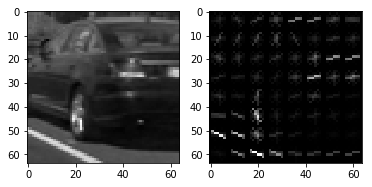

In [6]:
# Red Channel
_ = get_hog(cars[100][:,:,0], vis=True)
# Blue Channel
_ = get_hog(notcars[200][:,:,1], vis=True)
# Green Channel
_ = get_hog(cars[300][:,:,2], vis=True)

This is the result for YUV colorspace.

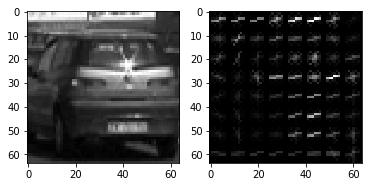

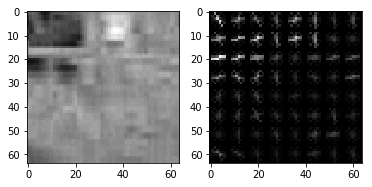

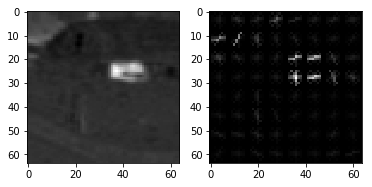

In [7]:
# Y Channel
_ = get_hog(cv2.cvtColor(cars[100], cv2.COLOR_RGB2YUV)[:,:,0], vis=True)
# U Channel
_ = get_hog(cv2.cvtColor(notcars[200], cv2.COLOR_RGB2YUV)[:,:,1], vis=True)
# V Channel
_ = get_hog(cv2.cvtColor(cars[300], cv2.COLOR_RGB2YUV)[:,:,2], vis=True)

I also experimented with dense SIFT features but they don't yield good results and appropriate to training the classifiers

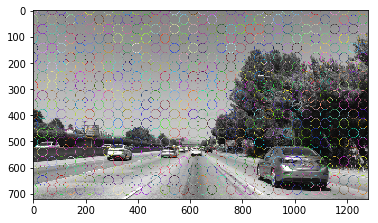

(128,)


In [8]:
sift_f = dense_SIFT(cv2.imread("output_images/bbox-example-image.jpg"), display=True)
print(sift_f.shape)

### Main pipeline

Below is the core code to extract HOG features and stack them into appropriate feature Numpy matrix. The function allows selection of methods (HOG or Dense SIFT) and selection of colorspace (HSV, LUV, HLS, YUV, YCrCb) and color channel (out of 3) to extract the features.

After a few experiment iterations, I decided on a default parameters which are `method='HOG', cspace='RGB', orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), hog_channel='ALL'`. They yield the highest performance given an acceptable extraction time.

In [9]:
def extract_features(data, method='HOG', cspace='RGB', orientations=9, 
                     pixels_per_cell=(8, 8), cells_per_block=(3, 3), hog_channel='ALL'):
    """Extract features for the dataset. Default is HOG.
    
    Returns: numpy array of (len(data), len(features)).
    
    """
    
    features = []
    # Loop through all images
    for image in data:
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if method == 'HOG':
            hog_features = []
            if hog_channel == 'ALL':     
                # For-loop through all channel
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog(feature_image[:,:,channel], orientations=orientations, 
                                                              pixels_per_cell=pixels_per_cell, 
                                                              cells_per_block=cells_per_block))
                hog_features = np.ravel(hog_features) # Make 3 sub-channel features, into 1 single array       
            else:
                hog_features = get_hog(feature_image[:,:,hog_channel], orientations=orientations, 
                                                              pixels_per_cell=pixels_per_cell, 
                                                              cells_per_block=cells_per_block)
            # Append the new feature vector to the features list
            features.append(hog_features)

        if method == 'SIFT':
            sift_features = dense_SIFT(feature_image)
            features.append(sift_features)

    return np.array(features).astype(np.float64)

In [10]:
cars_HOG_features = extract_features(cars, method='HOG', cspace='YUV', orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2))
notcars_HOG_features = extract_features(notcars, method='HOG', cspace='YUV', orientations=11, pixels_per_cell=(16, 16), cells_per_block=(2, 2))

In [11]:
print(cars_HOG_features.shape, notcars_HOG_features.shape)

(8792, 1188) (8968, 1188)


As shown, after flattened out, there are 1,188 features for 8,792 car images and 8,968 non-car images. For this exercise, this is a good amount of features to fit a linear classifier. The distribution of yes/no examples is balanced which will set up the classifier well.

2. Train a linear classifier
---

After feature extraction pipeline is setup, the car and non-car features are stacked in the X matrix. The cars examples are labeled as 1, non-cars are zero.

In [12]:
X = np.vstack([cars_HOG_features, notcars_HOG_features])
y = np.hstack([np.ones(cars_HOG_features.shape[0]), np.zeros(notcars_HOG_features.shape[0])])

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [14]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14208, 1188) (14208,) (3552, 1188) (3552,)


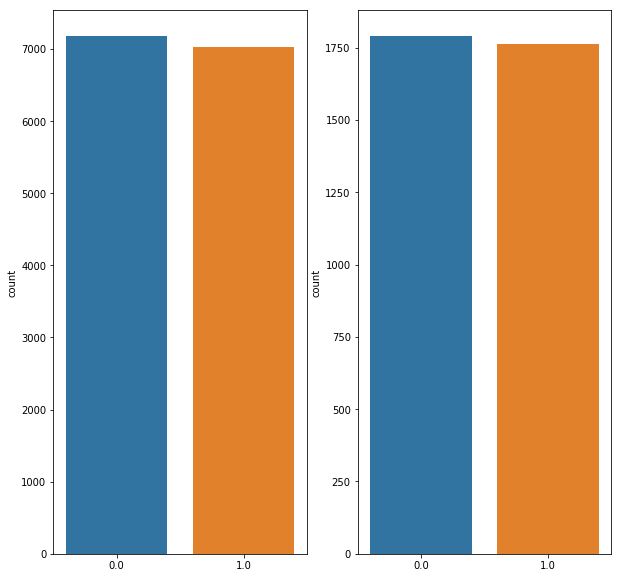

In [15]:
import seaborn as sns
plt.figure(figsize=(10,10))
plt.subplot(121)
sns.countplot(y_train)
plt.subplot(122)
sns.countplot(y_test)

In [16]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler # Helpful if we combine multiple methods. For now, it is just HOG.

svc_car = LinearSVC()
svc_car.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [17]:
print('Test Accuracy of SVC = ', round(svc_car.score(X_test, y_test), 4))

Test Accuracy of SVC =  0.9845


For the classifier choice, a Linear Support Vector Classifier was selected because of its simplicity and apparent test performance of above 95% for multiple experiment iterations or test splits.

3. Sliding Window Search and Classifier Application
---

Below is the code to perform window searches. It is adapted from the lessons and @jeremy-shannon.

For each window of an images, a corresponding window is extracted from the HOG feature matrix. This slice of feature matrix is fed into the classifier where it will produce inference of yes-car or no-car.

The positive predictions are then stored in a list and returned.

Without scaling, `scale = 1`:
* Image shape `(256, 1280, 3)`.
* With `orient=11, cell_per_block=2, pix_per_cell=16`, HOG for 1 layer is `(15, 79, 2, 2, 11)`. Because $(1280-16*2)/16 + 1 = 79$ and $(256-16*2)/16 + 1 = 15$, each block is $16*2$ pixels and next block adjacent to the previous block by 1 cell = 16 pixels.
* Now my window shape is `(64, 64)` which is correspond to $(\frac{64-32}{16}+1, 3, 2, 2, 11)$. Each car crop in the training set is also `(64, 64)`.
* From `(15, 79, 2, 2, 11)` and crop the `(3, 3, 2, 2, 11)` of the appropriate window.

In [21]:
def search_cars(img, ystart, ystop, scale, model, cspace='GRB', orient=11, pix_per_cell=16, 
                hog_channel='ALL', window=64, cells_per_step=2, cell_per_block=2, debug=False):
    """Search for car frames given sliding window and trained model.
    
    Reference: https://github.com/jeremy-shannon/CarND-Vehicle-Detection
    
    Returns: rectanle coordinates of cars found.
    """
    
    # Segment the image to relevant search section
    sub_img = img[ystart:ystop, :].astype(np.float32)/255
    
    # Change to desired color space
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(sub_img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(sub_img)   
    
    # Rescale
    if scale != 1:
        feature_image = cv2.resize(feature_image, (np.int(feature_image.shape[1]/scale), np.int(feature_image.shape[0]/scale)))
    hog_infos = []
    
    # Generate HOG features for the entire sub_image
    if hog_channel == 'ALL':
        for channel in range(feature_image.shape[2]):
            sub_hog = hog(feature_image[:, :, channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                       cells_per_block=(cell_per_block, cell_per_block), feature_vector=False)
            hog_infos.append(sub_hog)
        sub_hog1, sub_hog2, sub_hog3 = hog_infos
    else:
        sub_hog1 = hog(feature_image[:, :, 0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                       cells_per_block=(cell_per_block, cell_per_block), feature_vector=False)
    
    # Define blocks and steps as above
    x_window, y_window = window, window
    nxblocks = (feature_image.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (feature_image.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
                       
    car_rects = []
    full_rects = []
    
    # This is step number. Have to multiply it with cell_per_step to jump to the correct point.
    for y_step in range(nysteps):
        for x_step in range(nxsteps):
            y = y_step * cells_per_step
            x = x_step * cells_per_step
            feat1 = sub_hog1[y:(y+nblocks_per_window), x:(x+nblocks_per_window), :, :, :]
            feat2 = sub_hog2[y:(y+nblocks_per_window), x:(x+nblocks_per_window), :, :, :]
            feat3 = sub_hog3[y:(y+nblocks_per_window), x:(x+nblocks_per_window), :, :, :]
            
            test_feats = np.hstack((feat1.ravel(), feat2.ravel(), feat3.ravel()))
            pred = model.predict(test_feats.reshape(1, -1))
                
            bbox = ((np.int(x*pix_per_cell*scale), np.int(y*pix_per_cell*scale+ystart)), 
                    (np.int(x*pix_per_cell*scale+x_window*scale), np.int(y*pix_per_cell*scale+y_window*scale+ystart)))
            
            if pred == 1:
                car_rects.append(bbox)
            else:
                full_rects.append(bbox)
    
    if debug:
        return car_rects, full_rects
    else:
        return car_rects


def draw_boxes(img, rects, color=(0, 255, 0), show=False):    
    if len(rects) == 0:
        print("No cars found!")
        return img
    else:
        drawn = img.copy()
        for rect in rects:
            if color == 'random':
                color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            cv2.rectangle(drawn, rect[0], rect[1], color, 3)    
        if show:
            plt.figure(figsize=(10,10))
            plt.imshow(drawn)
        return drawn

Using the `test1.jpg` as the test image, using a window scale of 1 with default search y-axis from 350 pixel mark to 600 pixel mark, pretty much cover the entire view window of the car.

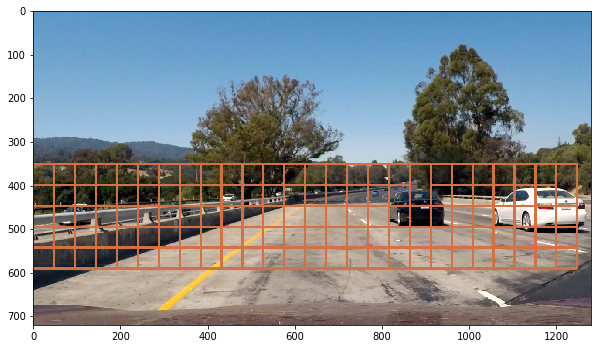

In [22]:
sample_img = mpimg.imread("test_images/test1.jpg")
drawn_sample = draw_boxes(sample_img, 
                          search_cars(sample_img, ystart=350, ystop=600, scale=1.5, model=svc_car, cspace='YUV', debug=True)[1], 
                          show=True, color='random')

Now filter for only positive predictions, we can see the classifier is working pretty well.

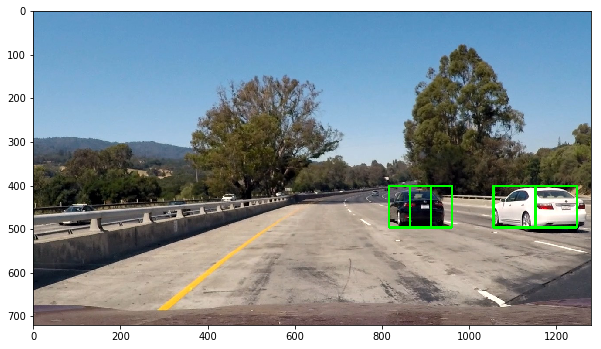

In [23]:
sample_img = mpimg.imread("test_images/test1.jpg")
sample_rects = search_cars(sample_img, ystart=400, ystop=656, scale=1.5, model=svc_car, cspace='YUV')
drawn_sample = draw_boxes(sample_img, sample_rects, show=True)

### Try different combinations of window searches

The following windows are suggested by @jeremy-shannon and combined with personal experiments. As shown, there are multiple overlapping bounding boxes that suggest there is a car present.

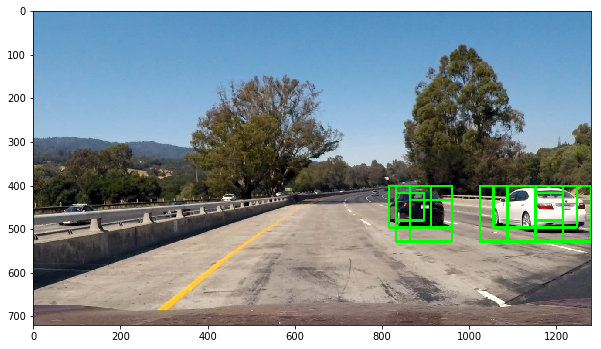

In [24]:
detected_rects = []

test_img = mpimg.imread('test_images/test1.jpg')

detected_rects.append(search_cars(test_img, ystart=400, ystop=464, scale=1.0, model=svc_car, cspace='YUV'))
detected_rects.append(search_cars(test_img, ystart=416, ystop=480, scale=1.0, model=svc_car, cspace='YUV'))
detected_rects.append(search_cars(test_img, ystart=400, ystop=496, scale=1.5, model=svc_car, cspace='YUV'))
detected_rects.append(search_cars(test_img, ystart=432, ystop=528, scale=1.5, model=svc_car, cspace='YUV'))
detected_rects.append(search_cars(test_img, ystart=400, ystop=528, scale=2.0, model=svc_car, cspace='YUV'))
detected_rects.append(search_cars(test_img, ystart=432, ystop=560, scale=2.0, model=svc_car, cspace='YUV'))
detected_rects.append(search_cars(test_img, ystart=400, ystop=596, scale=3.5, model=svc_car, cspace='YUV'))
detected_rects.append(search_cars(test_img, ystart=464, ystop=640, scale=3.5, model=svc_car, cspace='YUV'))

drawn_test_img = draw_boxes(test_img, [r for s in detected_rects for r in s], show=True)

4. Combining overlapping bounding boxes
---

An approach to combine overlapping bounding boxes, as suggested in the lessons, is using heatmap. For every pixel point of an image, its intensity will be amplified by the number of positive-predicted bounding boxes it belong too. 

The function `label_heatmap()` performs that operation on a zeros canvas same size of the original image.

The function also applies a Scipy method that can detect the non-zero elements in a bitwise (0 and 1 canvas) and assign them an index. 
```python 
from scipy.ndimage.measurements import label```

The left figure is just a normal heatmap with intensity. The right figure shows 2 connected regions corresponding to the 2 cars in the scene.

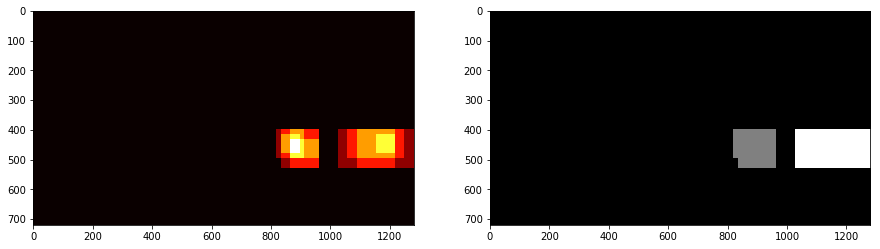

Number of cars: 2


In [35]:
from scipy.ndimage.measurements import label
def label_heatmap(img, rects, threshold, show_heatmap=False):
    """Draw overlapping bounding boxes as heatmaps."""
    canvas = np.zeros_like(img[:, :, 0])
    for r in rects:
        canvas[r[0][1]:r[1][1], r[0][0]:r[1][0]] += 1
    # Black out pixels < threshold
    canvas[canvas < threshold] = 0
    # Identify the islands
    islands, num_islands = label(canvas)
    if show_heatmap:
        plt.figure(figsize=(15, 15))
        plt.subplot(121)
        plt.imshow(canvas, cmap='hot')
        plt.subplot(122)
        plt.imshow(islands, cmap='gray')
        plt.show()
    return islands, num_islands

car_canvas, num_cars = label_heatmap(test_img, [r for s in detected_rects for r in s], 1, show_heatmap=True)
print("Number of cars: %d" %num_cars)

### Draw car frames

Now that we detect 2 isolated regions correponding to 2 cars in the frame, the top-left and bottom right coordinates for each island is extracted and drawn on the original image.

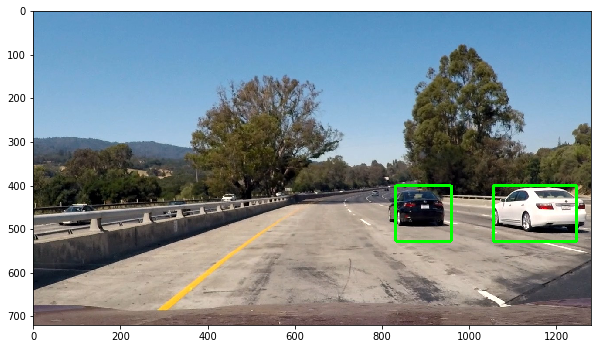

In [77]:
def draw_car_frames(img, detected_rects, threshold, color=(0, 255, 0)):
    car_canvas, num_cars = label_heatmap(test_img, detected_rects, threshold, show_heatmap=False)
    drawn = img.copy()
    for car_index in range(1, num_cars + 1):
        nonzero_idx = (car_canvas == car_index).nonzero()
        min_x, max_x = nonzero_idx[1].min(), nonzero_idx[1].max()
        min_y, max_y = nonzero_idx[0].min(), nonzero_idx[0].max()
        cv2.rectangle(drawn, (min_x, min_y), (max_x, max_y), color, 5)
    return drawn

drawn_final = draw_car_frames(test_img, [r for s in detected_rects for r in s], threshold=2)
plt.figure(figsize=(10, 10))
plt.imshow(drawn_final)

5. Put everything together and cache
---

The `CarSearchCache` class is defined to store the bounding boxes where the classifier predicts a car is present. However, it only store a limited number of history frames equal to `hist_len` which is set as 15 previous frames.

The whole pipeline to process the video is put together in the `process_frame(img)` method with a few default arguments such as `use_hist` to incorporate previous frames, and `color` to indicate the color to draw bounding boxes.

In [114]:
class CarSearchCache:
    def __init__(self, hist_len=10):
        self.hist = []
        self.hist_len = hist_len
    
    def add_rects(self, rects):
        self.hist += rects
        if len(self.hist) > self.hist_len:
            self.hist = self.hist[-self.hist_len:]

In [124]:
car_hist = CarSearchCache()
def process_frame(img, threshold=7, use_hist=True, color=(0, 255, 0)):
    """Process frames for video."""
    detected_rects = []
    detected_rects.append(search_cars(img, ystart=400, ystop=464, scale=1.0, model=svc_car, cspace='YUV'))
    detected_rects.append(search_cars(img, ystart=416, ystop=480, scale=1.0, model=svc_car, cspace='YUV'))
    detected_rects.append(search_cars(img, ystart=400, ystop=496, scale=1.5, model=svc_car, cspace='YUV'))
    detected_rects.append(search_cars(img, ystart=432, ystop=528, scale=1.5, model=svc_car, cspace='YUV'))
    detected_rects.append(search_cars(img, ystart=400, ystop=528, scale=2.0, model=svc_car, cspace='YUV'))
    detected_rects.append(search_cars(img, ystart=432, ystop=560, scale=2.0, model=svc_car, cspace='YUV'))
    detected_rects.append(search_cars(img, ystart=400, ystop=596, scale=3.5, model=svc_car, cspace='YUV'))
    detected_rects.append(search_cars(img, ystart=464, ystop=640, scale=3.5, model=svc_car, cspace='YUV'))
    detected_rects = [r for s in detected_rects for r in s]

    if use_hist:
        car_hist.add_rects(detected_rects)
        drawn_img = draw_car_frames(img, car_hist.hist, threshold, color=color)
    else:
        drawn_img = draw_car_frames(img, detected_rects, threshold, color=color)

    return drawn_img

### Try on test images

Performance is pretty good for `test1.jpg` and `test3.jpg`.

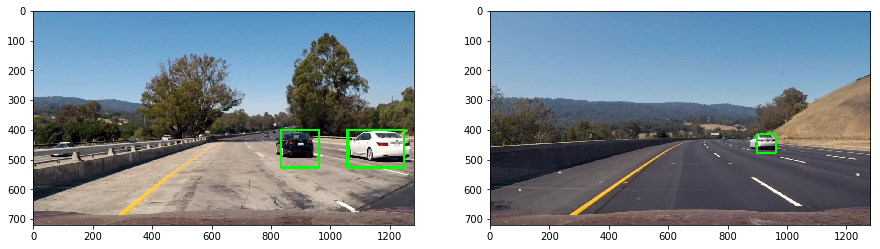

In [125]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(process_frame(mpimg.imread('test_images/test1.jpg'), threshold=2, use_hist=False))
plt.subplot(122)
plt.imshow(process_frame(mpimg.imread('test_images/test3.jpg'), threshold=2, use_hist=False))

Export to videos! Please find it in `test_output_video.mp4` and `project_output_video.mp4` in the top level of the repository.

In [126]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [127]:
test_clip = VideoFileClip('test_video.mp4')
test_output_clip = test_clip.fl_image(process_frame)
%time test_output_clip.write_videofile('test_output_video.mp4', audio=False, codec='libx264')

[MoviePy] >>>> Building video test_output_video.mp4
[MoviePy] Writing video test_output_video.mp4


 97%|█████████▋| 38/39 [00:07<00:00,  4.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output_video.mp4 

CPU times: user 29.5 s, sys: 127 ms, total: 29.7 s
Wall time: 8.45 s


In [128]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('test_output_video.mp4'))

In [129]:
project_clip = VideoFileClip('project_video.mp4')
project_output_clip = project_clip.fl_image(process_frame)
%time project_output_clip.write_videofile('project_output_video.mp4', audio=False, codec='libx264')

[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


100%|█████████▉| 1260/1261 [04:13<00:00,  5.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video.mp4 

CPU times: user 16min 20s, sys: 5.44 s, total: 16min 26s
Wall time: 4min 14s


In [130]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('project_output_video.mp4'))

Reflections
---

The output for test video is [here](test_output_video.mp4) and the output for project video is [here](project_output_video.mp4)

A few problems and suggested solutions can be in the following areas:

1) Feature selection and extraction
* For this exercise, I only stack HOG features for all 3-channel RGB colorspace for the feature matrix X. Although HOG is a great abstractor of an image, its features might not be complex enough to detect cars in an image frame. An ensemble solution can be done by combining HOG, color histogram, SIFT features, raw pixels.
* For HOG, the hyperparameters search might not be comprehensive and lead to to sub-optimal performance.

2) Classifier
* Typically, `LinearSVC()` is a robust method for simple primitive features and might have yielded 98%ish test accuracy. But it is extremely easy to overfit. For a high-stake situation like vehicle detection in self-driving car, a linear model might not be a good candidate to generalize high-pixel image frames well. Neural-based methods or non-linear classifiers should be used to account for the complexity of image features.
* More sample is always needed. In this exercise, we only have low-definition crops and less than 10,000 examples for cars and non-cars categories. A reliable system might require close to half a million images.

3) Window search and accuracy
* For this exercise, I only set the window search for the middle section of an image frame. To achieve a reliable performance, a window search might be performed on a larger portion of the image frame, which will result in speed compromise for the system. A few real-time object detection algorithms such as [YOLO](https://pjreddie.com/darknet/yolo/) might be a good candidate to avoid brute force a large number of unnecessary windows.
* As shown in the project output video, the first few minutes, there are a few false positives which might be catastrophic for a self-driving car. This can be avoided by training a better classifier, or incorporating a more sophisticated history cache to account for cars on the same journey.